In [31]:
#this script creates clustermap for all human and mouse individuals
#on tpm valyues for each of the 4 diverging groups human vs mouse in hagai in dsRNA system 


In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


#this script takes some edgeR table results and analize the expressed genes, try to understad which genes are differentialy expressed among the samples. 
#the analysis based on q_val
import sys
!{sys.executable} -m pip install sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
import math
import os

In [113]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

##### not relevant 
def prepare_FC_and_qval(edger_df):
    min_qval_after_zero=[num for num in list(edger_df['q_val']) if num>0][0]
    np.log10(min_qval_after_zero)+5
    safety= pow(10,np.log10(min_qval_after_zero)-1)
    new_min_qval = float(min_qval_after_zero) - float(safety)
    FC_col = 'logFC'
    Q_val_col = 'q_val'
    edgeR_data = edger_df[[FC_col, Q_val_col] ]
    add_edgeR_data = edgeR_data.assign(add_Q_val_col=np.add(new_min_qval,edgeR_data[Q_val_col]))
    add_log_edgeR_data = add_edgeR_data.assign(add_log_Q_val_col=np.log10(add_edgeR_data['add_Q_val_col']))
    add_minuslog_edgeR = add_log_edgeR_data.assign(minuslog_Q_val_col=add_log_edgeR_data['add_log_Q_val_col'].multiply(-1))

    return add_minuslog_edgeR

In [114]:
# creating heatMaps: 
os.makedirs(r'figures',exist_ok=True)

In [115]:
# open the big metadatand leave only 1-1
human_mouse_ortho=pd.read_csv(r'input\1-1_human_mouse_metadata.csv',index_col=0)
human_mouse_ortho_1_1=human_mouse_ortho[human_mouse_ortho['Mouse homology type']=='ortholog_one2one']
human_mouse_ortho_1_1


human_mouse_ortho_1_1.columns

# create 1-1 dict mouse>human ens names 
human_mouse_ortho_1_1_dict=dict(zip(human_mouse_ortho_1_1['Mouse gene stable ID'],human_mouse_ortho_1_1.index))

In [138]:
def heatmapping(group_to_subset, mus_homo_count_data,treat_of_interest,name_group_to_subset='not given-probably do not want to save heatmap',study='not given- heatmap isnt saved',species_title_for_COUNT_or_TPM='not given- heatmap isnt saved',vmin='',vmax=''):
    
    # a note - vmin and max are not relevant anymore but only leftover from former versions
    
    data_for_heatmap = mus_homo_count_data.loc[group_to_subset]
    print('len group to subset: {}'.format(len(group_to_subset)))
    # remove 6 homo becaues it looks not great
    relevant_samples = [sam for sam in data_for_heatmap.columns if ((treat_of_interest[0] in sam or treat_of_interest[1] in sam) ) ]# ADD that between '( (' :     and '6' not in sam
    # IFNB and UNS , or , PIC4 and LF4
    data_for_heatmap=data_for_heatmap[relevant_samples]
    
    # from here- its for when we want to log on the TPM!!!!! 
    # for log10 we need to make all zero's- not

    # find the nim num after 0 : 

    list_of_all_data_values = []
    for col in data_for_heatmap.values.tolist():
        for num in col:
            list_of_all_data_values.append(num)
        
    
    min_qval_after_zero=min([num for num in list_of_all_data_values if num>0])

    safety= pow(10,(np.log10(min_qval_after_zero))-1)

    new_min_qval = float(min_qval_after_zero) - float(safety)
    
    # adding this small value to all of the df
    add_data_for_heatmap = data_for_heatmap.add(new_min_qval)
    
    # log the df
    log_add_data_for_heatmap = np.log10(add_data_for_heatmap)
    np.max(log_add_data_for_heatmap.values)
    log_add_data_for_heatmap

    short_names_dict={'Mus_musculus':'Mouse','Homo_sapiens':'Human'}
    
    
    if (study=='Hagai') & (treat_of_interest==['LF4','PIC4']):
        log_add_data_for_heatmap.rename(columns={k:(k[6:-2]).replace('LF4_','control ').replace('PIC4_','dsRNA ').replace("Homo_sapiens",short_names_dict['Homo_sapiens']).replace("Mus_musculus",short_names_dict['Mus_musculus']) for k in log_add_data_for_heatmap.columns},inplace=True)
        log_add_data_for_heatmap
        
    if (study=='Hagai') & (treat_of_interest==['UNST','IFNB']):
        log_add_data_for_heatmap.rename(columns={k:(k[6:-2]).replace('UNST_','control ').replace('IFNB_','IFNB ').replace("Homo_sapiens",short_names_dict['Homo_sapiens']).replace("Mus_musculus",short_names_dict['Mus_musculus']) for k in log_add_data_for_heatmap.columns},inplace=True)
        log_add_data_for_heatmap

    
    
    
    samps_lables = log_add_data_for_heatmap.columns
    samps_lables
    #networks
    

    old_homo_stim='47c2fc'
    
    
     
    
    mus_stim_col='#e5a179'
    mus_cntl_col='#ffc3a0'
    homo_stim_col='#79BDE5'
    homo_cntl_col='#a0dcff'
    
    

    if (study=='Hagai') & (treat_of_interest==['LF4','PIC4']):
        samps_lut={'control {}'.format(short_names_dict['Mus_musculus']): mus_cntl_col,
                     'dsRNA {}'.format(short_names_dict['Mus_musculus']): mus_stim_col,
                     'control {}'.format(short_names_dict['Homo_sapiens']):homo_cntl_col,  
                     'dsRNA {}'.format(short_names_dict['Homo_sapiens']):homo_stim_col}
        # 89d5ff
        #FDA379
        
    if (study=='Hagai') & (treat_of_interest==['UNST','IFNB']):
        samps_lut={'control {}'.format(short_names_dict['Mus_musculus']): mus_cntl_col,
                     'IFNB {}'.format(short_names_dict['Mus_musculus']): mus_stim_col,
                     'control {}'.format(short_names_dict['Homo_sapiens']):homo_cntl_col,
                     'IFNB {}'.format(short_names_dict['Homo_sapiens']):homo_stim_col}

    
    
    
    #samps_pal = ['#98DDFF',"#FFB389",'#75BAF5',"#FF774D"]#sns.cubehelix_palette(samps_lables.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #samps_pal
    #network_pal = sns.cubehelix_palette(network_labels.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #samps_lut = dict(zip(map(str, samps_lables.unique()), samps_pal))
    #samps_lut


    # create network index
    samps_colors = pd.Series(samps_lables, index=log_add_data_for_heatmap.columns).map(samps_lut)
    samps_colors
    #  7491C3 C35758
    #cost_cmap=sns.diverging_palette((116 , 145 , 195), (195 , 87 , 88), as_cmap=True)
    cost_cmap='vlag'
    
    
    # Create an array with the colors you want to use
    #colors = ["#FF0B04", "#4374B3"]
# Set your custom color palette
    #cost_cmap=sns.set_palette(sns.color_palette(colors))
    
    g = sns.clustermap(log_add_data_for_heatmap,
    # Turn off the clustering
    row_cluster=True, col_cluster=True,
    # Add colored class labels using data frame created from node and network colors
    robust=True,
    col_colors = samps_colors,
    # Make the plot look better when many rows/cols
    linewidths=0,
    xticklabels=False, yticklabels=False,
    center=0
                       , cmap=cost_cmap
                      )

    # network legend
    for label in samps_lables.unique():
        g.ax_col_dendrogram.bar(0, 0, color=samps_lut[str(label)], label=label, linewidth=0)

    l1 = g.ax_col_dendrogram.legend(title='species',fontsize=14, loc='center', ncol=1, bbox_to_anchor=(1.2,0.55), bbox_transform=plt.gcf().transFigure)
   # plt.setp(g.get_legend().get_texts(), fontsize='20') 

         # for legend title
    #plt.setp(g.get_legend().get_title(), fontsize='20') 
    
    groups_names_dict={'STIM-high':'human constitutive-low',
                   'UNST-low':'human constitutive-high',
                   'STIM-low':'mouse constitutive-low',
                   'UNST-high':'mouse constitutive-high'}
    
    
    new_name_group=groups_names_dict[name_group_to_subset.split('_stri')[0].replace('_','-').replace('PIC4','STIM').replace('LF4','UNST')]
    
    plt.savefig(r'figures\heatmap_{}_{}_{}-{}_genes_TPMvalues_afterLog.pdf'.format(study,species_title_for_COUNT_or_TPM,name_group_to_subset,new_name_group))
    plt.savefig(r'figures\heatmap_{}_{}_{}-{}_genes_TPMvalues_afterLog.png'.format(study,species_title_for_COUNT_or_TPM,name_group_to_subset,new_name_group))
    
    plt.show()

    
    return g,log_add_data_for_heatmap
    


    


    

##### this func is not relevant but still here just in case... 
##### it is only if we plot on ploss?? 
def heatmapping_old(group_to_subset, mus_homo_count_data,treat_of_interest,name_group_to_subset='not given-probably do not want to save heatmap',study='not given- heatmap isnt saved',species_title_for_COUNT_or_TPM='not given- heatmap isnt saved',vmin='',vmax=''):
    data_for_heatmap = mus_homo_count_data.loc[group_to_subset]
    print('len group to subset: {}'.format(len(group_to_subset)))
    # remove 6 homo becaues it looks not great
    relevant_samples = [sam for sam in data_for_heatmap.columns if ((treat_of_interest[0] in sam or treat_of_interest[1] in sam) ) ]# ADD that between '( (' :     and '6' not in sam
    # IFNB and UNS , or , PIC4 and LF4
    data_for_heatmap=data_for_heatmap[relevant_samples]
    
    # from here- its for when we want to log on the TPM!!!!! 
    # for log10 we need to make all zero's- not

    # find the nim num after 0 : 

    list_of_all_data_values = []
    for col in data_for_heatmap.values.tolist():
        for num in col:
            list_of_all_data_values.append(num)
        
    
    min_qval_after_zero=min([num for num in list_of_all_data_values if num>0])

    safety= pow(10,(np.log10(min_qval_after_zero))-1)

    new_min_qval = float(min_qval_after_zero) - float(safety)
    
    # adding this small value to all of the df
    add_data_for_heatmap = data_for_heatmap.add(new_min_qval)
    
    # log the df
    log_add_data_for_heatmap = np.log10(add_data_for_heatmap)
    np.max(log_add_data_for_heatmap.values)
    log_add_data_for_heatmap

    #creating the heatmap:
    plt.figure(figsize=(16,9))

    sns.set_theme(color_codes=True)
    if vmin != '' and vmax!='':
        results=sns.clustermap(log_add_data_for_heatmap, center=0,vmin=vmin,vmax=vmax,yticklabels=False,cmap='coolwarm', figsize=(16, 9),annot_kws={"size": 16})
        plt.setp(results.get_legend().get_texts(), fontsize='20') 

         # for legend title
        plt.setp(results.get_legend().get_title(), fontsize='20') 
        
        
    elif vmax == '' and vmin =='':
        results=sns.clustermap(log_add_data_for_heatmap, center=0,yticklabels=False,cmap='coolwarm', figsize=(16, 9),annot_kws={"size": 16}) 
        plt.setp(results.get_legend().get_texts(), fontsize='20') 

         # for legend title
        plt.setp(results.get_legend().get_title(), fontsize='20') 
        plt.rc('xtick', labelsize=18)
    
    if study != 'not given- heatmap isnt saved':
        #saving acording to TPM values!  - if we want to save
        plt.savefig(r'C:\Users\TzachiHNB1\Documents\docs_from_lilac\tzachi_hagai\project_Sept5_2020_updated\primates_redents_analysis\heatmaps_for_validating_volcano_moderate\heatmap_{}_{}_{}_genes_TPMvalues_afterLog.pdf'.format(study,species_title_for_COUNT_or_TPM,name_group_to_subset))
    
    
    
    plt.show()

    return results
    


    


    

In [139]:
def create_the_heatmaps(study,species,treat): # species is for example ['homo','mus'] , # treat is PIC4/IFNB/treated , depends on study
    
    # a note - vmin and max are not relevant anymore but only leftover from former versions

    
    # define the groups: 

    study='Hagai'
    species=['homo','mus']
    if species==['homo','mus']:
        species_full_names=['Homo sapiens','Mus musculus']
        species_to_analyze = 'homo_vs_mus'
    treats=['LF4','PIC4']


    df_groups=pd.read_csv(r'input\{}_{}_vs_{}_{}_and_{}_groups_results.csv'.format(study,species[0],species[1],treats[0],treats[1]),index_col=0)
    df_groups

    DE_genes_FC_values_df=pd.read_csv(r'input\DE_genes_human_mouse_pic.csv',index_col=1)

    DE_genes=DE_genes_FC_values_df.index
    non_DE_genes=[i for i in human_mouse_ortho_1_1.index if i not in DE_genes]

    # stim groups - high and low
    group_stim_high=df_groups[(df_groups[f'group_{treats[1]}']==f'{treats[1]}_high_strict')|(df_groups[f'group_{treats[1]}']==f'{treats[1]}_high_moderate')]
    print(len(group_stim_high.index))
    group_stim_high_and_DE=[i for i in group_stim_high.index if i in DE_genes_FC_values_df.index]
    print(len(group_stim_high_and_DE))


    group_stim_low=df_groups[(df_groups[f'group_{treats[1]}']==f'{treats[1]}_low_strict')|(df_groups[f'group_{treats[1]}']==f'{treats[1]}_low_moderate')]
    print(len(group_stim_low.index))
    group_stim_low_and_DE=[i for i in group_stim_low.index if i in DE_genes_FC_values_df.index]
    print(len(group_stim_low_and_DE))


    # unst groups - high and low
    group_unst_high=df_groups[(df_groups[f'group_{treats[0]}']==f'{treats[0]}_high_strict')|(df_groups[f'group_{treats[0]}']==f'{treats[0]}_high_moderate')]
    print(len(group_unst_high.index))
    group_unst_high_and_DE=[i for i in group_unst_high.index if i in DE_genes_FC_values_df.index]
    print(len(group_unst_high_and_DE))


    group_unst_low=df_groups[(df_groups[f'group_{treats[0]}']==f'{treats[0]}_low_strict')|(df_groups[f'group_{treats[0]}']==f'{treats[0]}_low_moderate')]
    print(len(group_unst_low.index))
    group_unst_low_and_DE=[i for i in group_unst_low.index if i in DE_genes_FC_values_df.index]
    print(len(group_unst_low_and_DE))


    
    # open and define the TPM data: 
    species_title_for_COUNT_or_TPM=species_to_analyze
    
    #snother leftover:
    # remember- when writing 'mus_homo_count_data' it means rodent-primate! not nessaceraly mus and homo 
    #if species_to_analyze == 'homo_vs_mus':
        #species_title_for_COUNT_or_TPM = 'mus_and_homo'
    #    species_title_for_COUNT_or_TPM=species_to_analyze

    #elif species_to_analyze == 'macaca_vs_rattus':
        #species_title_for_COUNT_or_TPM = 'rat_and_macaca'
    #    species_title_for_COUNT_or_TPM=species_to_analyze
    #else:
    #    species_title_for_COUNT_or_TPM=species_to_analyze



    #mus_homo_count_data = pd.read_csv(r'C:\Users\TzachiHNB1\Documents\docs_from_lilac\tzachi_hagai\project_Sept5_2020_updated\primates_redents_analysis\{}_countData_{}.txt'.format(study,species_title_for_COUNT_or_TPM),sep = '\t',index_col=0)
    #mus_homo_count_data

    # TPM
    mus_homo_count_data = pd.read_csv(r'input\{}_tpmData_{}.txt'.format(species_title_for_COUNT_or_TPM,study),sep = '\t',index_col=0)
    mus_homo_count_data

    
    

    
    if treat=='PIC4':
        list_of_groups_unst_stim_dict = {'PIC4_high_strict':group_stim_high_and_DE,
                                'PIC4_low_strict':group_stim_low_and_DE,
                                'LF4_high_strict':group_unst_high_and_DE,
                                'LF4_low_strict':group_unst_low_and_DE}
    #old leftovers
    #elif treat=='IFNB':
    #    list_of_groups_unst_stim_dict = {'IFNB_high_strict':group_stim_high_and_DE,
    #                    'IFNB_low_strict':group_stim_low_and_DE, 
    #                  'UNST_high_strict':group_unst_high_and_DE, 
    #                  'UNST_low_strict':group_unst_low_and_DE}
    #    
    #elif treat=='treated':
    #    list_of_groups_unst_stim_dict = {'treated_high_strict':group_stim_high_and_DE, 
    #                            'treated_low_strict':group_stim_low_and_DE,
    #                            'mock_high_strict':group_unst_high_and_DE,
    #                            'mock_low_strict':group_unst_low_and_DE}

      
        # not relevant but not interupting... 
    vmin_vmax_dict={'PIC4_high_strict':[-2,2],
                   'PIC4_low_strict':[-2,2],
                   'LF4_high_strict':[-2,2],
                   'LF4_low_strict':[-2,3],
                    
                    'IFNB_high_strict':[-2,2.5],
                   'IFNB_low_strict':[-2,2.5],
                   'UNST_high_strict':[-2,2.5],
                   'UNST_low_strict':[-2,3],
                    
                    'treated_high_strict':[-2.5,3],
                   'treated_low_strict':[-2,3],
                   'mock_high_strict':[-1.5,3],
                   'mock_low_strict':[-2,2]
                   }
    
    groups_clustermap_dict={}
    for name,group in list_of_groups_unst_stim_dict.items():
        #intersect = [g for g in group if g in DE_genes_maya_data.index]
        #for i in intersect:
        #    print(i)
        intersect=group
        print(len(intersect))
        vmin=vmin_vmax_dict[name][0]
        vmax=vmin_vmax_dict[name][1]
        
        #if study=='Ploss':
        #    heat_res=heatmapping_old(group_to_subset=intersect, mus_homo_count_data=mus_homo_count_data,treat_of_interest = [treats[0],treats[1]], name_group_to_subset=name,study=study, species_title_for_COUNT_or_TPM=species_title_for_COUNT_or_TPM,vmin=vmin,vmax=vmax)
            # for legend text
         
        if study!='Ploss':
            heat_res,original_df=heatmapping(group_to_subset=intersect, mus_homo_count_data=mus_homo_count_data,treat_of_interest = [treats[0],treats[1]], name_group_to_subset=name,study=study, species_title_for_COUNT_or_TPM=species_title_for_COUNT_or_TPM,vmin=vmin,vmax=vmax)
    # for legend text
            groups_clustermap_dict[name]=[intersect,heat_res,original_df]
            
    
    #heatmaps_dict[name]= [heat_res,intersect,[],[],[]]
        print('{} genes are DE in {} from {} genes \n\n'.format(len(intersect),name, len(group)))
    return groups_clustermap_dict
        
    

579
224
519
166
498
104
476
84
224
len group to subset: 224


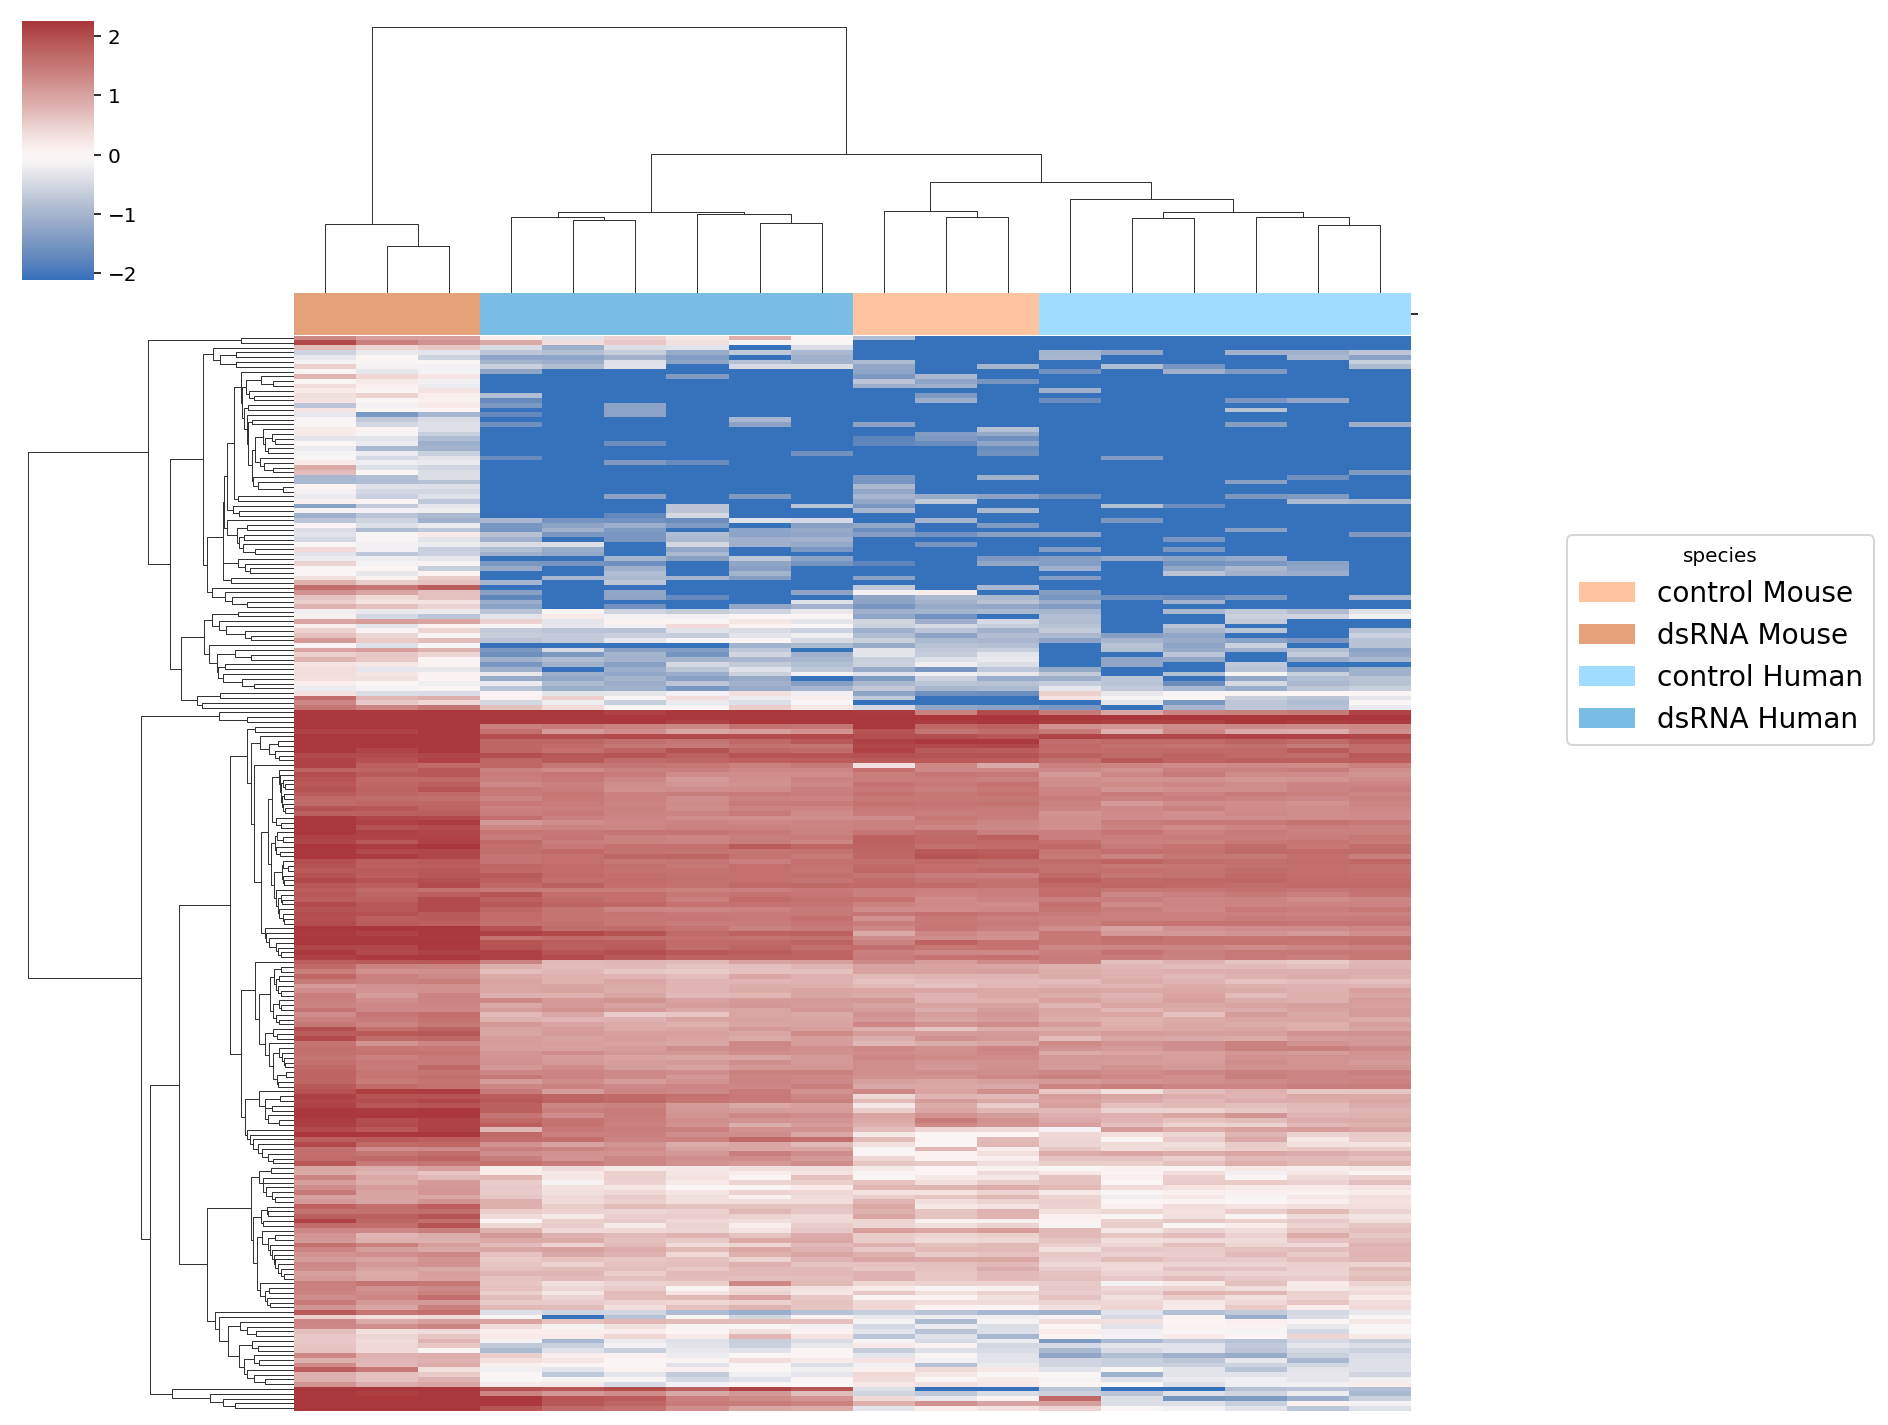

224 genes are DE in PIC4_high_strict from 224 genes 


166
len group to subset: 166


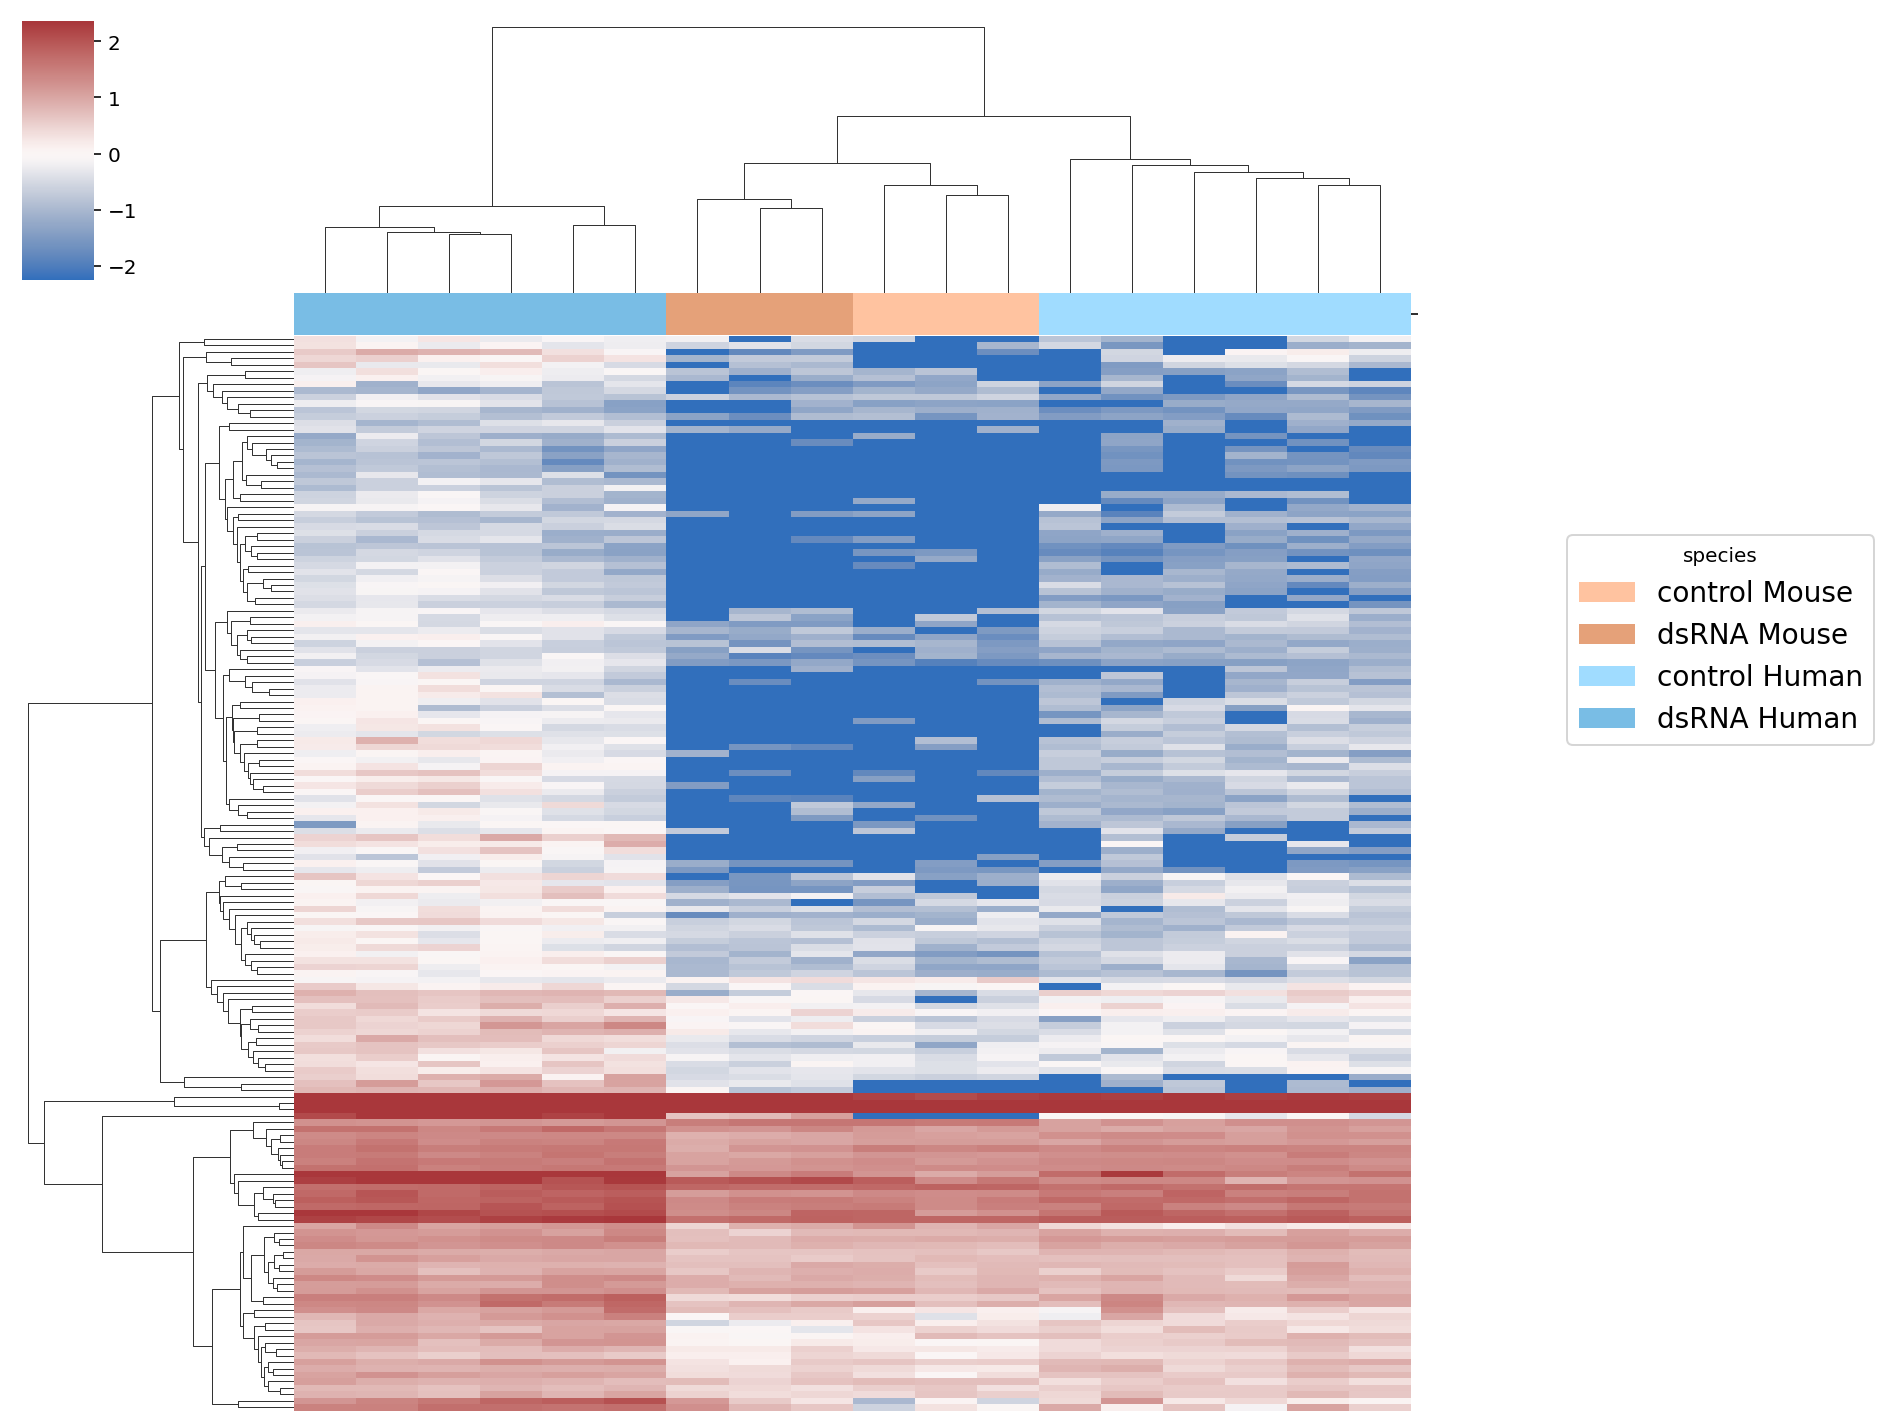

166 genes are DE in PIC4_low_strict from 166 genes 


104
len group to subset: 104


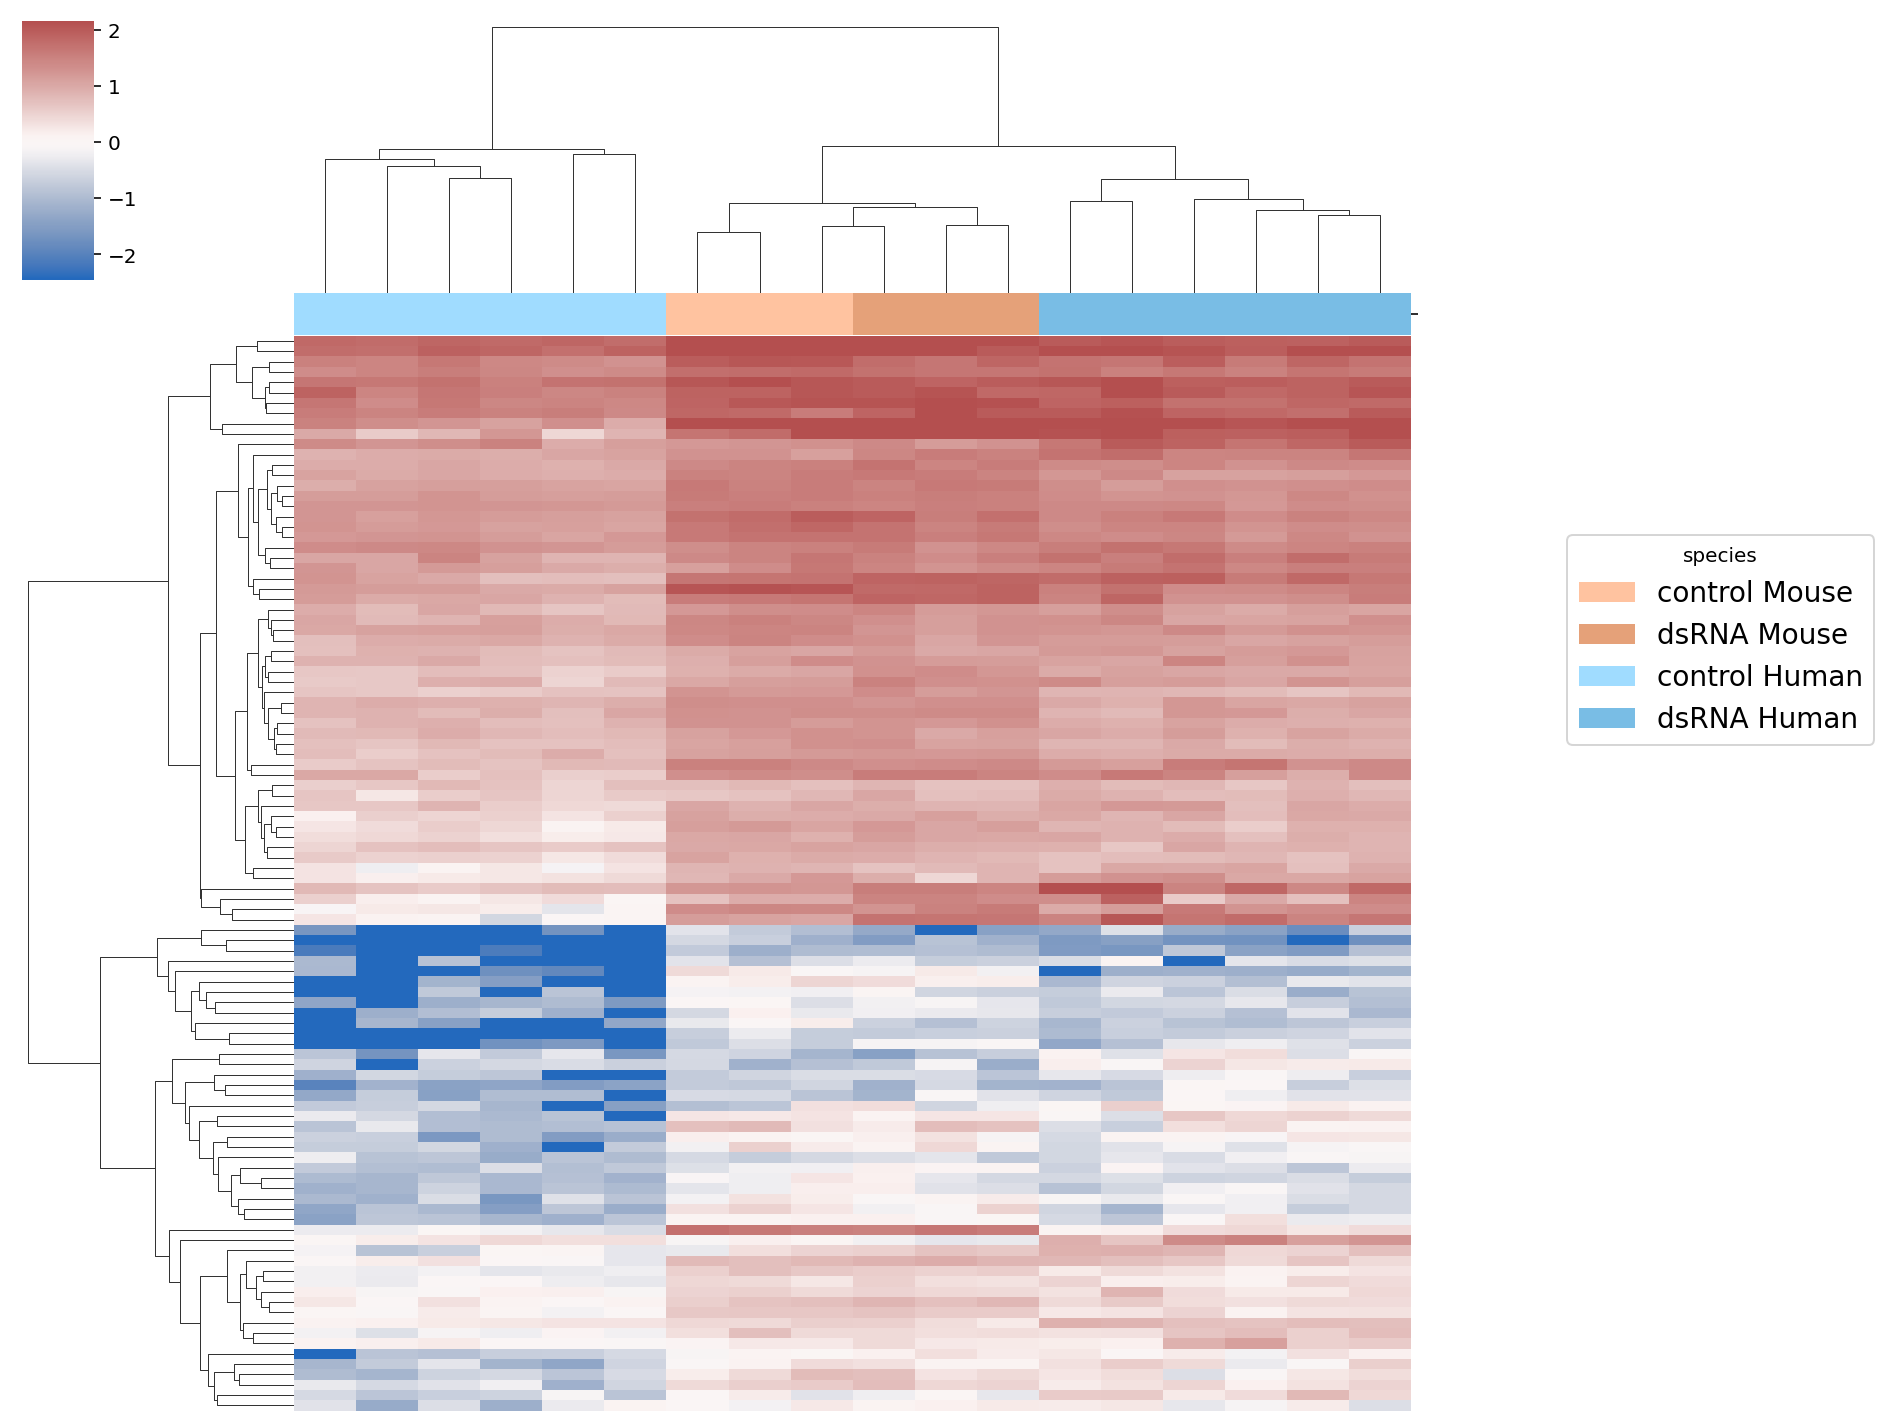

104 genes are DE in LF4_high_strict from 104 genes 


84
len group to subset: 84


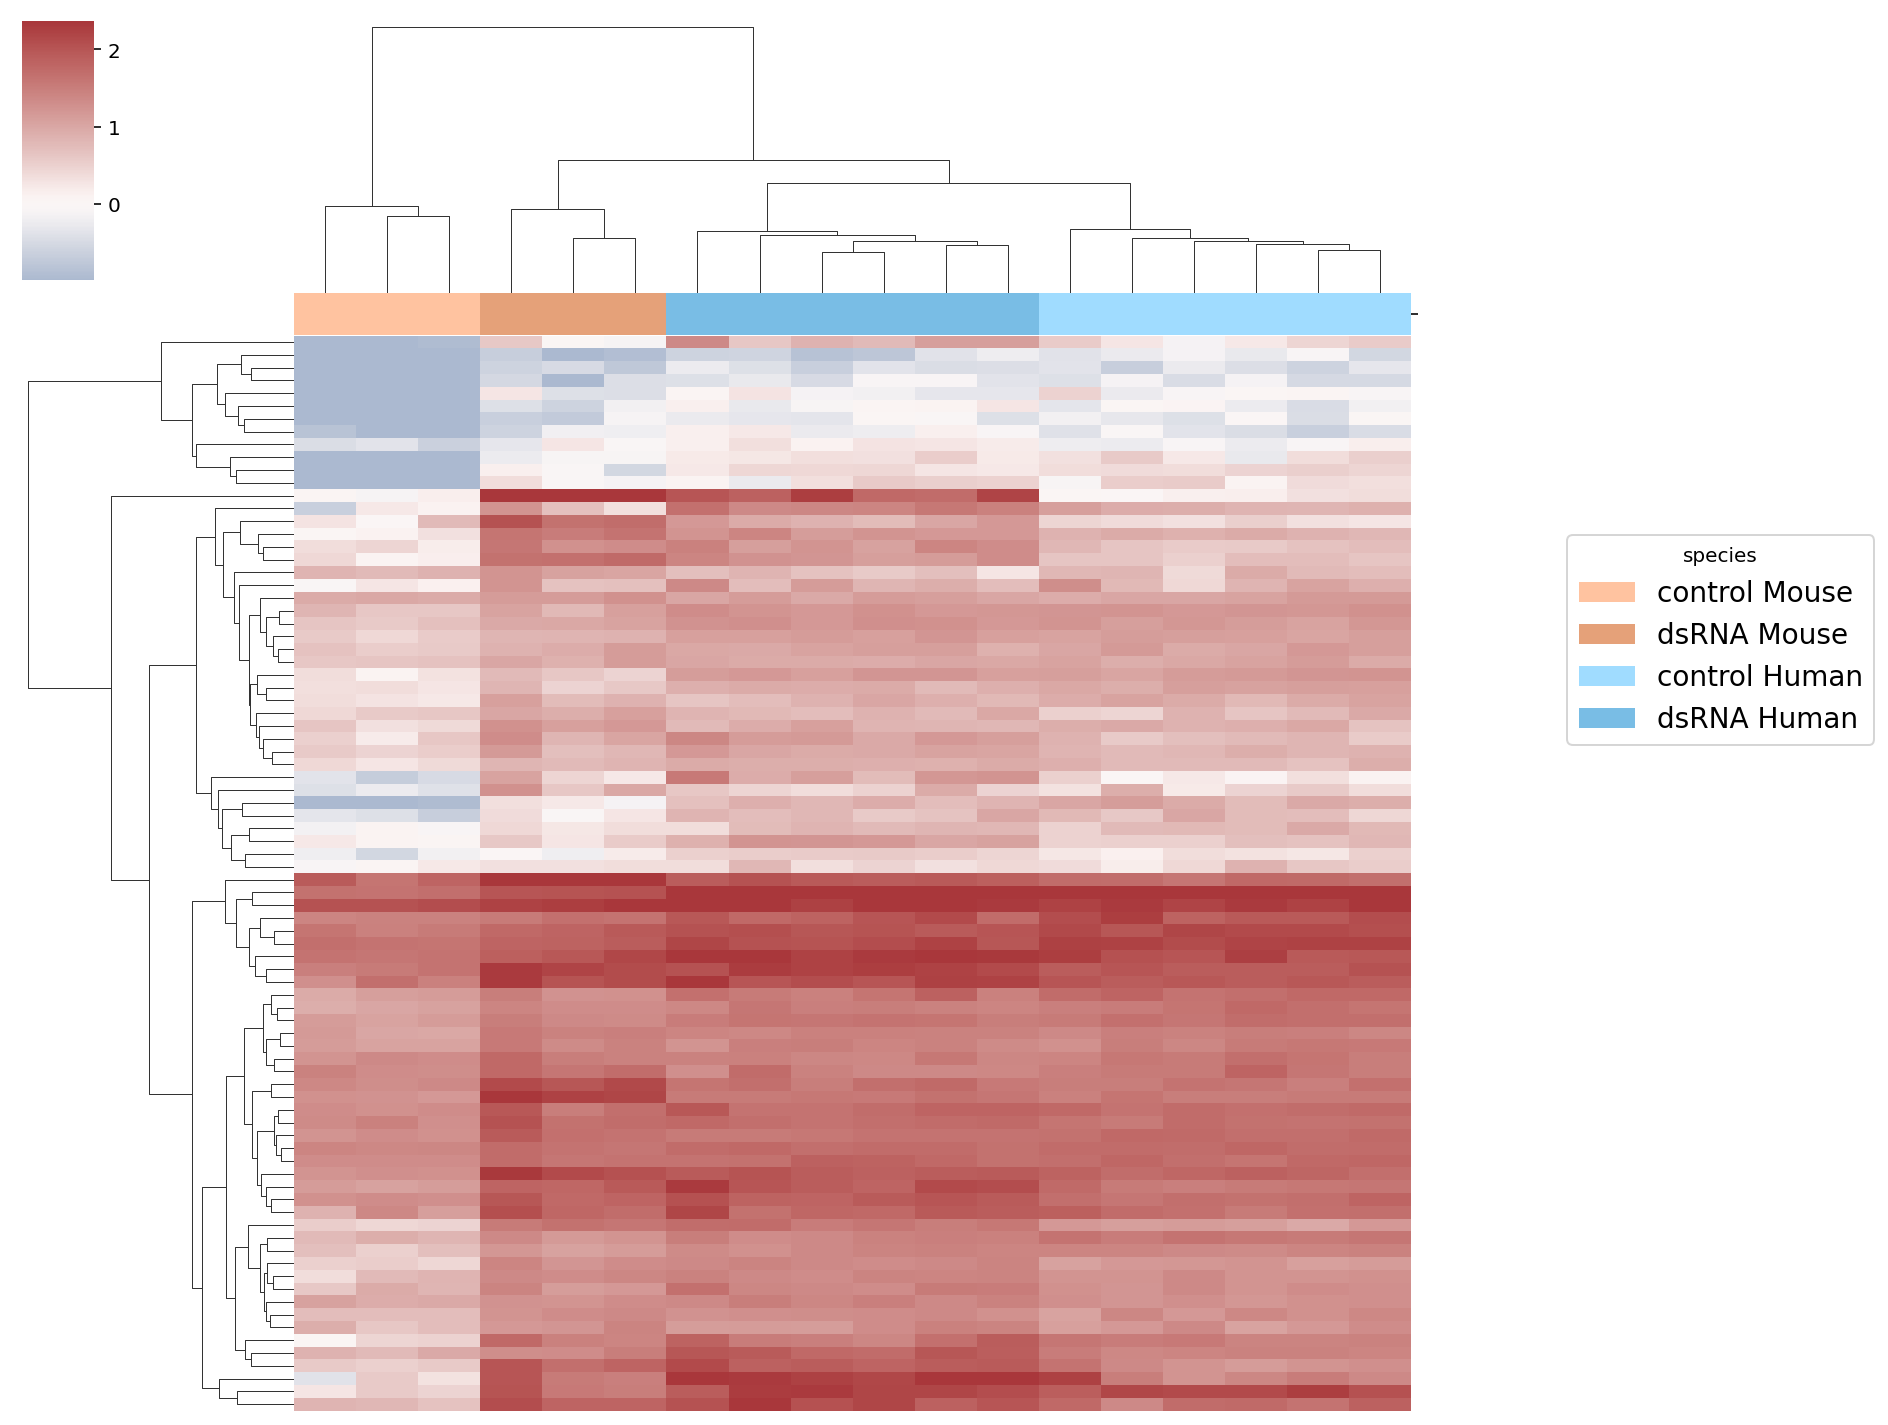

84 genes are DE in LF4_low_strict from 84 genes 




{'PIC4_high_strict': [['ENSG00000164949',
   'ENSG00000138802',
   'ENSG00000204209',
   'ENSG00000155313',
   'ENSG00000109320',
   'ENSG00000149115',
   'ENSG00000169905',
   'ENSG00000143337',
   'ENSG00000198060',
   'ENSG00000164136',
   'ENSG00000162298',
   'ENSG00000178927',
   'ENSG00000111224',
   'ENSG00000007384',
   'ENSG00000179021',
   'ENSG00000115325',
   'ENSG00000146232',
   'ENSG00000147454',
   'ENSG00000132669',
   'ENSG00000168795',
   'ENSG00000081019',
   'ENSG00000168071',
   'ENSG00000137193',
   'ENSG00000015475',
   'ENSG00000136732',
   'ENSG00000163932',
   'ENSG00000107485',
   'ENSG00000184811',
   'ENSG00000135604',
   'ENSG00000006652',
   'ENSG00000136854',
   'ENSG00000138496',
   'ENSG00000184545',
   'ENSG00000153975',
   'ENSG00000205593',
   'ENSG00000079691',
   'ENSG00000116977',
   'ENSG00000176994',
   'ENSG00000180448',
   'ENSG00000269855',
   'ENSG00000118946',
   'ENSG00000032219',
   'ENSG00000116990',
   'ENSG00000196843',
   'ENSG0000

In [140]:
res = create_the_heatmaps(study='Hagai',species=['homo','mus'],treat='PIC4')
res

In [141]:
# old leftovers... 
# create_the_heatmaps(study='Hagai',species=['homo','mus'],treat='IFNB')

In [142]:
# oldleftovers... 
# create_the_heatmaps(study='Ploss',species=['homo','mus'],treat='treated')

In [ ]:
# get the original df before plotting and save (the columns are not ordered)

In [143]:
clustermaps_groups={}

In [144]:
groups_names_dict={'STIM-high':'human constitutive-low',
                   'UNST-low':'human constitutive-high',
                   'STIM-low':'mouse constitutive-low',
                   'UNST-high':'mouse constitutive-high'}
    

In [145]:
for k,v in res.items():
    group_name=k
    genes_names_group=v[0]
    clustergrid_obj=v[1]
    reorder_index=clustergrid_obj.dendrogram_row.reordered_ind
    reorder_columns=clustergrid_obj.dendrogram_col.reordered_ind
    original_df=v[2]
    
    
    
    #original_df.rename(columns=(col_names_to_nums_dict),inplace=True)
    #print((original_df))
    
    #original_df['gene']=original_df.index
    #print(original_df)
    
    
    original_df_reset=original_df.reset_index()
    
    #print(original_df_reset)
    
    
    original_reorder=original_df_reset.loc[reorder_index]
    #print(original_reorder)

    
    #original_reorder = original_reorder.reindex(sorted(original_reorder.columns), axis=1)
    original_reorder.to_csv(r'figures\clustermap_df_{}_{}_{}-{}_genes.csv'.format(study,species_title_for_COUNT_or_TPM,k,new_name_group))

